# Atmospheric Simulation 

In this notebook you may find a really dummy atmospheric simulation performed with `pycal`. We use the LSPE/STRIP focal plane and we simulate the correlation level between the detectors. 

As you know, the atmosphere load is not uniform also for a CES. The telescope line of sight scan the atmospheric structure and the load fluctuations are recorded in the TOD. So, if you look the single detector TOD, you can see very large fluctuations due to the water vapor structures that are just seen by this specific detector.

The temporal correlation is not the only correlated noise intruduced by the atmospheric load. The same vater wapor structures that was seen previously by that specific decetor, are seen also by others detectors in the focal planes. In this way we can find also a spatial correlation between the detector.

### A recap:
- The single detector TOD present time correlation due to the atmospheric structures (Time Correlation)
- These atmospheric structures are seen also by the other detectors of the focal plane, so they introduce a really strong level of correlation between them. (Spatial Correlation)

The most commons strategies to reduce the atmospheric effects are focused on mitigation of the spatial correlations between the detectors. This process can be done in different ways, using a rotating HWP (or more in general a polarization modulator) that works really good if your signal is polarized, and using the boresight axis of the telescope in the scanning strategy. We can see that only the correct use of the boresight axis can largely mitigated the atmospheric noise.


In [1]:
import pycal
from pycal.utils import Logger, Environment
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pylab as plt
from pycal.mpi import MPI, Comm, get_world
from pycal.todmap import *
from pycal import Data
from pycal.weather import Weather
from pycal.todmap.atm import AtmSim

In [2]:
log = Logger.get()
env = Environment.get()
mpiworld, procs, rank = get_world()

if rank == 0:
    print(env)
if mpiworld is None:
    print("Running serially with one process at {}".format(str(datetime.now())))
else:
    if rank == 0:
        print(
            "Running with {} processes at {}".format(procs, str(datetime.now()))
        )
comm = Comm(world=mpiworld)

data = Data(comm)

atm = pycal.todmap.OpSimAtmosphere()
# now we have: mpiworld, procs, rank, comm



<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 12
  MPI build enabled
  MPI runtime enabled
>
Running with 1 processes at 2020-12-12 17:32:57.327099


In [3]:
atm.exec(data)

UnboundLocalError: local variable 'comm' referenced before assignment

In [ ]:
data.obs

# Load the weather file

The weather file was built out of MERRA2 reanalysis data, and provides the cumulative distrubution functions of the atmospheric parameters that characterize the atmosphere above the Tenerife island, in particular, above the Teide Observatory.

Out of CDF, we can randomly extract the value of the PWV, wind speed and direction, ground temperature, pressure and all of these weight to the season of the year and the hour of the day

In [ ]:
year=2020
month=4
day=28
hour=20
primes=0
seconds=0

data=datetime(year, month, day, hour, primes, seconds)
timestamp=data.timestamp()

weather=Weather("weather_STRIP.fits")
weather.set_time(int(timestamp))

In [ ]:
# H20 in atmpsphere
pwv=weather.pwv
ice=weather.ice_water
liq=weather.liquid_water
hum=weather.humidity

# Temperaure and pressure
t0=weather.surface_temperature
t10=weather.air_temperature
p0=weather.surface_pressure

# Wind speed and direction
wx=weather.west_wind
wy=weather.south_wind
w = np.sqrt(wx**2 + wy**2)
w_dir = np.arctan2(wy, wx)

print("T0="+str(t0))
print("W ="+str(w))
print("W_dir="+str(w_dir))

In [ ]:
azmin=(0/180)*np.pi
azmax=(359/180)*np.pi
elmin=(60/180)*np.pi
elmax=(80/180)*np.pi
tmin=0.0
tmax_sim=1000.0
tmax_tod=tmax_sim
lmin_center=0.01
lmin_sigma=0.001
lmax_center=10
lmax_sigma=10
w_center=w
w_sigma=0
wdir_center=w_dir
#wdir_center=np.pi/2
wdir_sigma=0
z0_center=2000
z0_sigma=0
T0_center=t10
T0_sigma=0
zatm=40000.0
zmax=2000.0
xstep=100.0
ystep=100.0
zstep=100.0
nelem_sim_max=100000
verbosity=1
comm=comm
key1=0
key2=2**32+1+1
counterval1=0
counterval2=0
cachedir="/home/algebrato/Progetti/CMB4G/libcal/cookbook/atm_cache_noMPI"
rmin=0
rmax=10000

### The environment

In [4]:
#if rank==0:
env=pycal.Environment.get()
print(env)
print(tmax_tod/450)

<cal.Environment
  Source code version = 0.0.0
  Logging level = INFO
  Handling enabled for 0 signals:
  Max threads = 12
  MPI build enabled
  MPI runtime enabled
>


NameError: name 'tmax_tod' is not defined

### Scanning Strategy

In [5]:
# samples frequency
fs_hz=20
# timestamp in seconds (now we simulate 1h of observations)
times=np.linspace(0,tmax_tod,int(tmax_tod)*fs_hz)

# Now we perform a really dummy CES at 72deg of elevation
# and with an AZ span of 10deg
el=np.ones(int(tmax_tod)*fs_hz)*(72/180)*np.pi
# Fixed telescope
#az=np.ones(int(tmax_tod)*fs_hz)*(270/180)*np.pi

# A dummy scanning strategy
azmin_tod=(60/180)*np.pi
azmax_tod=(315/180)*np.pi
az = (0.5*(azmax_tod - azmin_tod)*np.sin((2*np.pi/500)*times)) + (0.5*(azmax_tod + azmin_tod))


NameError: name 'tmax_tod' is not defined

In [6]:
# The LSPE/STRIP Focalplane

import yaml
with open(r'/home/algebrato/.julia/dev/Stripeline/instrumentdb/strip_focal_plane.yaml') as file:
    focalplane=yaml.full_load(file)

detecotrs=focalplane['horns'].keys()
tod=dict()
pointings=dict()

theta_i = 0
theta_f = 90
bor = (((70/2)*np.sin(2*np.pi/150*times)+(70/2))/180)*np.pi

for i in detecotrs:
    directions=focalplane['horns'][i]['orientation']
    l=np.arctan(directions[0]/directions[2])
    u=np.arctan(directions[1]/directions[2])
    tod[i]={'signal':np.zeros(int(tmax_tod)*fs_hz), 'l':l, 'u':u}
    pointings[i]={'az':az+(l*np.cos(bor)-u*np.sin(bor)), 'el':el+(u*np.cos(bor)+l*np.sin(bor))}
    
    
obs=dict()
obs['name'] = "Strip_1H_Full_Focal_Plane"
obs['tod'] = tod
obs['pointings'] = pointings

data=pycal.Data(comm)

data.obs.append(obs)

NameError: name 'times' is not defined

In [7]:
detecotrs

dict_keys(['I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'O0', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'G0', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6'])

### Create the atmospheric simulation

The `AtmSimMPI` creates an atmosphere out of the principat weather parameter like <br/>
$L_0$, $l_0$ = The outer and inner correlation length, respectively. They depend on the energy injection and dissipation prosess within the atmosphere.<br/>
$w$, $w_{dir}$ = The wind speed and directions. The wind blows the atmospheric structes rigidly across the telescope line of sight.<br/>
$Z_0$ = The cut-off altitude of the water vapor<br/>
$T_0$ = The ground temeperature. In `pycal` the vetial gradient of temperature is considered linear. The tropopause discontinituy is negligible due to the water-vapor cut-off.


In [11]:
atm=AtmSim(azmin=(-10/180)*np.pi, azmax=(10/180)*np.pi, elmin=(60/180)*np.pi, elmax=(70/180)*np.pi, tmin=0, tmax=600, lmin_center=0.01, lmin_sigma=0.001, lmax_center=10, lmax_sigma=1, w_center=5, w_sigma=1, wdir_center=0, wdir_sigma=0.001, z0_center=2000, z0_sigma=10, T0_center=290, T0_sigma=4, zatm=20000, zmax=40000, xstep=100, ystep=100, zstep=100, nelem_sim_max=1000, verbosity=16, key1=123, key2=456, counterval1=789, counterval2=102213, cachedir='atm', rmin=0, rmax=10000)

In [12]:
# Start the atmosphere simulation (Evaluation of the correlations and wind evolutions)
err = atm.simulate(True)

In [23]:
tod={'signal':np.array([]), 'l':0, 'u':0}
atm.observe(np.linspace(0, 100, 1000), np.linspace(0, (10/180)*np.pi, 1000), np.ones(1000)*(65/180)*np.pi, tod)

TypeError: observe(): incompatible function arguments. The following argument types are supported:
    1. (self: pycal._libcal.AtmSim, times: buffer, az: buffer, el: buffer, tod: buffer, fixed_r: float = -1.0) -> int

Invoked with: <cal.AtmSim0 : cachedir atm
0 : ntask = 1, nthread = 12
0 : verbosity = 16, key1 = 123, key2 = 456, counter1 = 789, counter2 = 161013, counter1start = 789, counter2start = 102213
0 : azmin = -0.174533, axmax = 0.174533, elmin = 1.0472, elmax = 1.22173, tmin = 0, tmax = 600, sinel0 = 0.906308, cosel0 = 0.422618, tanmin = -0.178127, tanmax = 0.178127
0 : lmin_center = 0.01, lmax_center = 10, w_center = 5, w_sigma = 1, wdir_center = 0, wdir_sigma = 0.001, z0_center = 2000, z0_sigma = 10, T0_center = 290, T0_sigma = 4, z0inv = 0.000248527
>, array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.8028028 ,   2.9029029 ,   3.003003  ,   3.1031031 ,
         3.2032032 ,   3.3033033 ,   3.4034034 ,   3.5035035 ,
         3.6036036 ,   3.7037037 ,   3.8038038 ,   3.9039039 ,
         4.004004  ,   4.1041041 ,   4.2042042 ,   4.3043043 ,
         4.4044044 ,   4.5045045 ,   4.6046046 ,   4.7047047 ,
         4.8048048 ,   4.9049049 ,   5.00500501,   5.10510511,
         5.20520521,   5.30530531,   5.40540541,   5.50550551,
         5.60560561,   5.70570571,   5.80580581,   5.90590591,
         6.00600601,   6.10610611,   6.20620621,   6.30630631,
         6.40640641,   6.50650651,   6.60660661,   6.70670671,
         6.80680681,   6.90690691,   7.00700701,   7.10710711,
         7.20720721,   7.30730731,   7.40740741,   7.50750751,
         7.60760761,   7.70770771,   7.80780781,   7.90790791,
         8.00800801,   8.10810811,   8.20820821,   8.30830831,
         8.40840841,   8.50850851,   8.60860861,   8.70870871,
         8.80880881,   8.90890891,   9.00900901,   9.10910911,
         9.20920921,   9.30930931,   9.40940941,   9.50950951,
         9.60960961,   9.70970971,   9.80980981,   9.90990991,
        10.01001001,  10.11011011,  10.21021021,  10.31031031,
        10.41041041,  10.51051051,  10.61061061,  10.71071071,
        10.81081081,  10.91091091,  11.01101101,  11.11111111,
        11.21121121,  11.31131131,  11.41141141,  11.51151151,
        11.61161161,  11.71171171,  11.81181181,  11.91191191,
        12.01201201,  12.11211211,  12.21221221,  12.31231231,
        12.41241241,  12.51251251,  12.61261261,  12.71271271,
        12.81281281,  12.91291291,  13.01301301,  13.11311311,
        13.21321321,  13.31331331,  13.41341341,  13.51351351,
        13.61361361,  13.71371371,  13.81381381,  13.91391391,
        14.01401401,  14.11411411,  14.21421421,  14.31431431,
        14.41441441,  14.51451451,  14.61461461,  14.71471471,
        14.81481481,  14.91491491,  15.01501502,  15.11511512,
        15.21521522,  15.31531532,  15.41541542,  15.51551552,
        15.61561562,  15.71571572,  15.81581582,  15.91591592,
        16.01601602,  16.11611612,  16.21621622,  16.31631632,
        16.41641642,  16.51651652,  16.61661662,  16.71671672,
        16.81681682,  16.91691692,  17.01701702,  17.11711712,
        17.21721722,  17.31731732,  17.41741742,  17.51751752,
        17.61761762,  17.71771772,  17.81781782,  17.91791792,
        18.01801802,  18.11811812,  18.21821822,  18.31831832,
        18.41841842,  18.51851852,  18.61861862,  18.71871872,
        18.81881882,  18.91891892,  19.01901902,  19.11911912,
        19.21921922,  19.31931932,  19.41941942,  19.51951952,
        19.61961962,  19.71971972,  19.81981982,  19.91991992,
        20.02002002,  20.12012012,  20.22022022,  20.32032032,
        20.42042042,  20.52052052,  20.62062062,  20.72072072,
        20.82082082,  20.92092092,  21.02102102,  21.12112112,
        21.22122122,  21.32132132,  21.42142142,  21.52152152,
        21.62162162,  21.72172172,  21.82182182,  21.92192192,
        22.02202202,  22.12212212,  22.22222222,  22.32232232,
        22.42242242,  22.52252252,  22.62262262,  22.72272272,
        22.82282282,  22.92292292,  23.02302302,  23.12312312,
        23.22322322,  23.32332332,  23.42342342,  23.52352352,
        23.62362362,  23.72372372,  23.82382382,  23.92392392,
        24.02402402,  24.12412412,  24.22422422,  24.32432432,
        24.42442442,  24.52452452,  24.62462462,  24.72472472,
        24.82482482,  24.92492492,  25.02502503,  25.12512513,
        25.22522523,  25.32532533,  25.42542543,  25.52552553,
        25.62562563,  25.72572573,  25.82582583,  25.92592593,
        26.02602603,  26.12612613,  26.22622623,  26.32632633,
        26.42642643,  26.52652653,  26.62662663,  26.72672673,
        26.82682683,  26.92692693,  27.02702703,  27.12712713,
        27.22722723,  27.32732733,  27.42742743,  27.52752753,
        27.62762763,  27.72772773,  27.82782783,  27.92792793,
        28.02802803,  28.12812813,  28.22822823,  28.32832833,
        28.42842843,  28.52852853,  28.62862863,  28.72872873,
        28.82882883,  28.92892893,  29.02902903,  29.12912913,
        29.22922923,  29.32932933,  29.42942943,  29.52952953,
        29.62962963,  29.72972973,  29.82982983,  29.92992993,
        30.03003003,  30.13013013,  30.23023023,  30.33033033,
        30.43043043,  30.53053053,  30.63063063,  30.73073073,
        30.83083083,  30.93093093,  31.03103103,  31.13113113,
        31.23123123,  31.33133133,  31.43143143,  31.53153153,
        31.63163163,  31.73173173,  31.83183183,  31.93193193,
        32.03203203,  32.13213213,  32.23223223,  32.33233233,
        32.43243243,  32.53253253,  32.63263263,  32.73273273,
        32.83283283,  32.93293293,  33.03303303,  33.13313313,
        33.23323323,  33.33333333,  33.43343343,  33.53353353,
        33.63363363,  33.73373373,  33.83383383,  33.93393393,
        34.03403403,  34.13413413,  34.23423423,  34.33433433,
        34.43443443,  34.53453453,  34.63463463,  34.73473473,
        34.83483483,  34.93493493,  35.03503504,  35.13513514,
        35.23523524,  35.33533534,  35.43543544,  35.53553554,
        35.63563564,  35.73573574,  35.83583584,  35.93593594,
        36.03603604,  36.13613614,  36.23623624,  36.33633634,
        36.43643644,  36.53653654,  36.63663664,  36.73673674,
        36.83683684,  36.93693694,  37.03703704,  37.13713714,
        37.23723724,  37.33733734,  37.43743744,  37.53753754,
        37.63763764,  37.73773774,  37.83783784,  37.93793794,
        38.03803804,  38.13813814,  38.23823824,  38.33833834,
        38.43843844,  38.53853854,  38.63863864,  38.73873874,
        38.83883884,  38.93893894,  39.03903904,  39.13913914,
        39.23923924,  39.33933934,  39.43943944,  39.53953954,
        39.63963964,  39.73973974,  39.83983984,  39.93993994,
        40.04004004,  40.14014014,  40.24024024,  40.34034034,
        40.44044044,  40.54054054,  40.64064064,  40.74074074,
        40.84084084,  40.94094094,  41.04104104,  41.14114114,
        41.24124124,  41.34134134,  41.44144144,  41.54154154,
        41.64164164,  41.74174174,  41.84184184,  41.94194194,
        42.04204204,  42.14214214,  42.24224224,  42.34234234,
        42.44244244,  42.54254254,  42.64264264,  42.74274274,
        42.84284284,  42.94294294,  43.04304304,  43.14314314,
        43.24324324,  43.34334334,  43.44344344,  43.54354354,
        43.64364364,  43.74374374,  43.84384384,  43.94394394,
        44.04404404,  44.14414414,  44.24424424,  44.34434434,
        44.44444444,  44.54454454,  44.64464464,  44.74474474,
        44.84484484,  44.94494494,  45.04504505,  45.14514515,
        45.24524525,  45.34534535,  45.44544545,  45.54554555,
        45.64564565,  45.74574575,  45.84584585,  45.94594595,
        46.04604605,  46.14614615,  46.24624625,  46.34634635,
        46.44644645,  46.54654655,  46.64664665,  46.74674675,
        46.84684685,  46.94694695,  47.04704705,  47.14714715,
        47.24724725,  47.34734735,  47.44744745,  47.54754755,
        47.64764765,  47.74774775,  47.84784785,  47.94794795,
        48.04804805,  48.14814815,  48.24824825,  48.34834835,
        48.44844845,  48.54854855,  48.64864865,  48.74874875,
        48.84884885,  48.94894895,  49.04904905,  49.14914915,
        49.24924925,  49.34934935,  49.44944945,  49.54954955,
        49.64964965,  49.74974975,  49.84984985,  49.94994995,
        50.05005005,  50.15015015,  50.25025025,  50.35035035,
        50.45045045,  50.55055055,  50.65065065,  50.75075075,
        50.85085085,  50.95095095,  51.05105105,  51.15115115,
        51.25125125,  51.35135135,  51.45145145,  51.55155155,
        51.65165165,  51.75175175,  51.85185185,  51.95195195,
        52.05205205,  52.15215215,  52.25225225,  52.35235235,
        52.45245245,  52.55255255,  52.65265265,  52.75275275,
        52.85285285,  52.95295295,  53.05305305,  53.15315315,
        53.25325325,  53.35335335,  53.45345345,  53.55355355,
        53.65365365,  53.75375375,  53.85385385,  53.95395395,
        54.05405405,  54.15415415,  54.25425425,  54.35435435,
        54.45445445,  54.55455455,  54.65465465,  54.75475475,
        54.85485485,  54.95495495,  55.05505506,  55.15515516,
        55.25525526,  55.35535536,  55.45545546,  55.55555556,
        55.65565566,  55.75575576,  55.85585586,  55.95595596,
        56.05605606,  56.15615616,  56.25625626,  56.35635636,
        56.45645646,  56.55655656,  56.65665666,  56.75675676,
        56.85685686,  56.95695696,  57.05705706,  57.15715716,
        57.25725726,  57.35735736,  57.45745746,  57.55755756,
        57.65765766,  57.75775776,  57.85785786,  57.95795796,
        58.05805806,  58.15815816,  58.25825826,  58.35835836,
        58.45845846,  58.55855856,  58.65865866,  58.75875876,
        58.85885886,  58.95895896,  59.05905906,  59.15915916,
        59.25925926,  59.35935936,  59.45945946,  59.55955956,
        59.65965966,  59.75975976,  59.85985986,  59.95995996,
        60.06006006,  60.16016016,  60.26026026,  60.36036036,
        60.46046046,  60.56056056,  60.66066066,  60.76076076,
        60.86086086,  60.96096096,  61.06106106,  61.16116116,
        61.26126126,  61.36136136,  61.46146146,  61.56156156,
        61.66166166,  61.76176176,  61.86186186,  61.96196196,
        62.06206206,  62.16216216,  62.26226226,  62.36236236,
        62.46246246,  62.56256256,  62.66266266,  62.76276276,
        62.86286286,  62.96296296,  63.06306306,  63.16316316,
        63.26326326,  63.36336336,  63.46346346,  63.56356356,
        63.66366366,  63.76376376,  63.86386386,  63.96396396,
        64.06406406,  64.16416416,  64.26426426,  64.36436436,
        64.46446446,  64.56456456,  64.66466466,  64.76476476,
        64.86486486,  64.96496496,  65.06506507,  65.16516517,
        65.26526527,  65.36536537,  65.46546547,  65.56556557,
        65.66566567,  65.76576577,  65.86586587,  65.96596597,
        66.06606607,  66.16616617,  66.26626627,  66.36636637,
        66.46646647,  66.56656657,  66.66666667,  66.76676677,
        66.86686687,  66.96696697,  67.06706707,  67.16716717,
        67.26726727,  67.36736737,  67.46746747,  67.56756757,
        67.66766767,  67.76776777,  67.86786787,  67.96796797,
        68.06806807,  68.16816817,  68.26826827,  68.36836837,
        68.46846847,  68.56856857,  68.66866867,  68.76876877,
        68.86886887,  68.96896897,  69.06906907,  69.16916917,
        69.26926927,  69.36936937,  69.46946947,  69.56956957,
        69.66966967,  69.76976977,  69.86986987,  69.96996997,
        70.07007007,  70.17017017,  70.27027027,  70.37037037,
        70.47047047,  70.57057057,  70.67067067,  70.77077077,
        70.87087087,  70.97097097,  71.07107107,  71.17117117,
        71.27127127,  71.37137137,  71.47147147,  71.57157157,
        71.67167167,  71.77177177,  71.87187187,  71.97197197,
        72.07207207,  72.17217217,  72.27227227,  72.37237237,
        72.47247247,  72.57257257,  72.67267267,  72.77277277,
        72.87287287,  72.97297297,  73.07307307,  73.17317317,
        73.27327327,  73.37337337,  73.47347347,  73.57357357,
        73.67367367,  73.77377377,  73.87387387,  73.97397397,
        74.07407407,  74.17417417,  74.27427427,  74.37437437,
        74.47447447,  74.57457457,  74.67467467,  74.77477477,
        74.87487487,  74.97497497,  75.07507508,  75.17517518,
        75.27527528,  75.37537538,  75.47547548,  75.57557558,
        75.67567568,  75.77577578,  75.87587588,  75.97597598,
        76.07607608,  76.17617618,  76.27627628,  76.37637638,
        76.47647648,  76.57657658,  76.67667668,  76.77677678,
        76.87687688,  76.97697698,  77.07707708,  77.17717718,
        77.27727728,  77.37737738,  77.47747748,  77.57757758,
        77.67767768,  77.77777778,  77.87787788,  77.97797798,
        78.07807808,  78.17817818,  78.27827828,  78.37837838,
        78.47847848,  78.57857858,  78.67867868,  78.77877878,
        78.87887888,  78.97897898,  79.07907908,  79.17917918,
        79.27927928,  79.37937938,  79.47947948,  79.57957958,
        79.67967968,  79.77977978,  79.87987988,  79.97997998,
        80.08008008,  80.18018018,  80.28028028,  80.38038038,
        80.48048048,  80.58058058,  80.68068068,  80.78078078,
        80.88088088,  80.98098098,  81.08108108,  81.18118118,
        81.28128128,  81.38138138,  81.48148148,  81.58158158,
        81.68168168,  81.78178178,  81.88188188,  81.98198198,
        82.08208208,  82.18218218,  82.28228228,  82.38238238,
        82.48248248,  82.58258258,  82.68268268,  82.78278278,
        82.88288288,  82.98298298,  83.08308308,  83.18318318,
        83.28328328,  83.38338338,  83.48348348,  83.58358358,
        83.68368368,  83.78378378,  83.88388388,  83.98398398,
        84.08408408,  84.18418418,  84.28428428,  84.38438438,
        84.48448448,  84.58458458,  84.68468468,  84.78478478,
        84.88488488,  84.98498498,  85.08508509,  85.18518519,
        85.28528529,  85.38538539,  85.48548549,  85.58558559,
        85.68568569,  85.78578579,  85.88588589,  85.98598599,
        86.08608609,  86.18618619,  86.28628629,  86.38638639,
        86.48648649,  86.58658659,  86.68668669,  86.78678679,
        86.88688689,  86.98698699,  87.08708709,  87.18718719,
        87.28728729,  87.38738739,  87.48748749,  87.58758759,
        87.68768769,  87.78778779,  87.88788789,  87.98798799,
        88.08808809,  88.18818819,  88.28828829,  88.38838839,
        88.48848849,  88.58858859,  88.68868869,  88.78878879,
        88.88888889,  88.98898899,  89.08908909,  89.18918919,
        89.28928929,  89.38938939,  89.48948949,  89.58958959,
        89.68968969,  89.78978979,  89.88988989,  89.98998999,
        90.09009009,  90.19019019,  90.29029029,  90.39039039,
        90.49049049,  90.59059059,  90.69069069,  90.79079079,
        90.89089089,  90.99099099,  91.09109109,  91.19119119,
        91.29129129,  91.39139139,  91.49149149,  91.59159159,
        91.69169169,  91.79179179,  91.89189189,  91.99199199,
        92.09209209,  92.19219219,  92.29229229,  92.39239239,
        92.49249249,  92.59259259,  92.69269269,  92.79279279,
        92.89289289,  92.99299299,  93.09309309,  93.19319319,
        93.29329329,  93.39339339,  93.49349349,  93.59359359,
        93.69369369,  93.79379379,  93.89389389,  93.99399399,
        94.09409409,  94.19419419,  94.29429429,  94.39439439,
        94.49449449,  94.59459459,  94.69469469,  94.79479479,
        94.89489489,  94.99499499,  95.0950951 ,  95.1951952 ,
        95.2952953 ,  95.3953954 ,  95.4954955 ,  95.5955956 ,
        95.6956957 ,  95.7957958 ,  95.8958959 ,  95.995996  ,
        96.0960961 ,  96.1961962 ,  96.2962963 ,  96.3963964 ,
        96.4964965 ,  96.5965966 ,  96.6966967 ,  96.7967968 ,
        96.8968969 ,  96.996997  ,  97.0970971 ,  97.1971972 ,
        97.2972973 ,  97.3973974 ,  97.4974975 ,  97.5975976 ,
        97.6976977 ,  97.7977978 ,  97.8978979 ,  97.997998  ,
        98.0980981 ,  98.1981982 ,  98.2982983 ,  98.3983984 ,
        98.4984985 ,  98.5985986 ,  98.6986987 ,  98.7987988 ,
        98.8988989 ,  98.998999  ,  99.0990991 ,  99.1991992 ,
        99.2992993 ,  99.3993994 ,  99.4994995 ,  99.5995996 ,
        99.6996997 ,  99.7997998 ,  99.8998999 , 100.        ]), array([0.        , 0.00017471, 0.00034942, 0.00052412, 0.00069883,
       0.00087354, 0.00104825, 0.00122295, 0.00139766, 0.00157237,
       0.00174708, 0.00192178, 0.00209649, 0.0022712 , 0.00244591,
       0.00262061, 0.00279532, 0.00297003, 0.00314474, 0.00331945,
       0.00349415, 0.00366886, 0.00384357, 0.00401828, 0.00419298,
       0.00436769, 0.0045424 , 0.00471711, 0.00489181, 0.00506652,
       0.00524123, 0.00541594, 0.00559064, 0.00576535, 0.00594006,
       0.00611477, 0.00628947, 0.00646418, 0.00663889, 0.0068136 ,
       0.00698831, 0.00716301, 0.00733772, 0.00751243, 0.00768714,
       0.00786184, 0.00803655, 0.00821126, 0.00838597, 0.00856067,
       0.00873538, 0.00891009, 0.0090848 , 0.0092595 , 0.00943421,
       0.00960892, 0.00978363, 0.00995834, 0.01013304, 0.01030775,
       0.01048246, 0.01065717, 0.01083187, 0.01100658, 0.01118129,
       0.011356  , 0.0115307 , 0.01170541, 0.01188012, 0.01205483,
       0.01222953, 0.01240424, 0.01257895, 0.01275366, 0.01292836,
       0.01310307, 0.01327778, 0.01345249, 0.0136272 , 0.0138019 ,
       0.01397661, 0.01415132, 0.01432603, 0.01450073, 0.01467544,
       0.01485015, 0.01502486, 0.01519956, 0.01537427, 0.01554898,
       0.01572369, 0.01589839, 0.0160731 , 0.01624781, 0.01642252,
       0.01659723, 0.01677193, 0.01694664, 0.01712135, 0.01729606,
       0.01747076, 0.01764547, 0.01782018, 0.01799489, 0.01816959,
       0.0183443 , 0.01851901, 0.01869372, 0.01886842, 0.01904313,
       0.01921784, 0.01939255, 0.01956725, 0.01974196, 0.01991667,
       0.02009138, 0.02026609, 0.02044079, 0.0206155 , 0.02079021,
       0.02096492, 0.02113962, 0.02131433, 0.02148904, 0.02166375,
       0.02183845, 0.02201316, 0.02218787, 0.02236258, 0.02253728,
       0.02271199, 0.0228867 , 0.02306141, 0.02323612, 0.02341082,
       0.02358553, 0.02376024, 0.02393495, 0.02410965, 0.02428436,
       0.02445907, 0.02463378, 0.02480848, 0.02498319, 0.0251579 ,
       0.02533261, 0.02550731, 0.02568202, 0.02585673, 0.02603144,
       0.02620614, 0.02638085, 0.02655556, 0.02673027, 0.02690498,
       0.02707968, 0.02725439, 0.0274291 , 0.02760381, 0.02777851,
       0.02795322, 0.02812793, 0.02830264, 0.02847734, 0.02865205,
       0.02882676, 0.02900147, 0.02917617, 0.02935088, 0.02952559,
       0.0297003 , 0.02987501, 0.03004971, 0.03022442, 0.03039913,
       0.03057384, 0.03074854, 0.03092325, 0.03109796, 0.03127267,
       0.03144737, 0.03162208, 0.03179679, 0.0319715 , 0.0321462 ,
       0.03232091, 0.03249562, 0.03267033, 0.03284503, 0.03301974,
       0.03319445, 0.03336916, 0.03354387, 0.03371857, 0.03389328,
       0.03406799, 0.0342427 , 0.0344174 , 0.03459211, 0.03476682,
       0.03494153, 0.03511623, 0.03529094, 0.03546565, 0.03564036,
       0.03581506, 0.03598977, 0.03616448, 0.03633919, 0.0365139 ,
       0.0366886 , 0.03686331, 0.03703802, 0.03721273, 0.03738743,
       0.03756214, 0.03773685, 0.03791156, 0.03808626, 0.03826097,
       0.03843568, 0.03861039, 0.03878509, 0.0389598 , 0.03913451,
       0.03930922, 0.03948393, 0.03965863, 0.03983334, 0.04000805,
       0.04018276, 0.04035746, 0.04053217, 0.04070688, 0.04088159,
       0.04105629, 0.041231  , 0.04140571, 0.04158042, 0.04175512,
       0.04192983, 0.04210454, 0.04227925, 0.04245395, 0.04262866,
       0.04280337, 0.04297808, 0.04315279, 0.04332749, 0.0435022 ,
       0.04367691, 0.04385162, 0.04402632, 0.04420103, 0.04437574,
       0.04455045, 0.04472515, 0.04489986, 0.04507457, 0.04524928,
       0.04542398, 0.04559869, 0.0457734 , 0.04594811, 0.04612282,
       0.04629752, 0.04647223, 0.04664694, 0.04682165, 0.04699635,
       0.04717106, 0.04734577, 0.04752048, 0.04769518, 0.04786989,
       0.0480446 , 0.04821931, 0.04839401, 0.04856872, 0.04874343,
       0.04891814, 0.04909284, 0.04926755, 0.04944226, 0.04961697,
       0.04979168, 0.04996638, 0.05014109, 0.0503158 , 0.05049051,
       0.05066521, 0.05083992, 0.05101463, 0.05118934, 0.05136404,
       0.05153875, 0.05171346, 0.05188817, 0.05206287, 0.05223758,
       0.05241229, 0.052587  , 0.05276171, 0.05293641, 0.05311112,
       0.05328583, 0.05346054, 0.05363524, 0.05380995, 0.05398466,
       0.05415937, 0.05433407, 0.05450878, 0.05468349, 0.0548582 ,
       0.0550329 , 0.05520761, 0.05538232, 0.05555703, 0.05573173,
       0.05590644, 0.05608115, 0.05625586, 0.05643057, 0.05660527,
       0.05677998, 0.05695469, 0.0571294 , 0.0573041 , 0.05747881,
       0.05765352, 0.05782823, 0.05800293, 0.05817764, 0.05835235,
       0.05852706, 0.05870176, 0.05887647, 0.05905118, 0.05922589,
       0.0594006 , 0.0595753 , 0.05975001, 0.05992472, 0.06009943,
       0.06027413, 0.06044884, 0.06062355, 0.06079826, 0.06097296,
       0.06114767, 0.06132238, 0.06149709, 0.06167179, 0.0618465 ,
       0.06202121, 0.06219592, 0.06237062, 0.06254533, 0.06272004,
       0.06289475, 0.06306946, 0.06324416, 0.06341887, 0.06359358,
       0.06376829, 0.06394299, 0.0641177 , 0.06429241, 0.06446712,
       0.06464182, 0.06481653, 0.06499124, 0.06516595, 0.06534065,
       0.06551536, 0.06569007, 0.06586478, 0.06603949, 0.06621419,
       0.0663889 , 0.06656361, 0.06673832, 0.06691302, 0.06708773,
       0.06726244, 0.06743715, 0.06761185, 0.06778656, 0.06796127,
       0.06813598, 0.06831068, 0.06848539, 0.0686601 , 0.06883481,
       0.06900951, 0.06918422, 0.06935893, 0.06953364, 0.06970835,
       0.06988305, 0.07005776, 0.07023247, 0.07040718, 0.07058188,
       0.07075659, 0.0709313 , 0.07110601, 0.07128071, 0.07145542,
       0.07163013, 0.07180484, 0.07197954, 0.07215425, 0.07232896,
       0.07250367, 0.07267838, 0.07285308, 0.07302779, 0.0732025 ,
       0.07337721, 0.07355191, 0.07372662, 0.07390133, 0.07407604,
       0.07425074, 0.07442545, 0.07460016, 0.07477487, 0.07494957,
       0.07512428, 0.07529899, 0.0754737 , 0.07564841, 0.07582311,
       0.07599782, 0.07617253, 0.07634724, 0.07652194, 0.07669665,
       0.07687136, 0.07704607, 0.07722077, 0.07739548, 0.07757019,
       0.0777449 , 0.0779196 , 0.07809431, 0.07826902, 0.07844373,
       0.07861843, 0.07879314, 0.07896785, 0.07914256, 0.07931727,
       0.07949197, 0.07966668, 0.07984139, 0.0800161 , 0.0801908 ,
       0.08036551, 0.08054022, 0.08071493, 0.08088963, 0.08106434,
       0.08123905, 0.08141376, 0.08158846, 0.08176317, 0.08193788,
       0.08211259, 0.0822873 , 0.082462  , 0.08263671, 0.08281142,
       0.08298613, 0.08316083, 0.08333554, 0.08351025, 0.08368496,
       0.08385966, 0.08403437, 0.08420908, 0.08438379, 0.08455849,
       0.0847332 , 0.08490791, 0.08508262, 0.08525732, 0.08543203,
       0.08560674, 0.08578145, 0.08595616, 0.08613086, 0.08630557,
       0.08648028, 0.08665499, 0.08682969, 0.0870044 , 0.08717911,
       0.08735382, 0.08752852, 0.08770323, 0.08787794, 0.08805265,
       0.08822735, 0.08840206, 0.08857677, 0.08875148, 0.08892619,
       0.08910089, 0.0892756 , 0.08945031, 0.08962502, 0.08979972,
       0.08997443, 0.09014914, 0.09032385, 0.09049855, 0.09067326,
       0.09084797, 0.09102268, 0.09119738, 0.09137209, 0.0915468 ,
       0.09172151, 0.09189621, 0.09207092, 0.09224563, 0.09242034,
       0.09259505, 0.09276975, 0.09294446, 0.09311917, 0.09329388,
       0.09346858, 0.09364329, 0.093818  , 0.09399271, 0.09416741,
       0.09434212, 0.09451683, 0.09469154, 0.09486624, 0.09504095,
       0.09521566, 0.09539037, 0.09556508, 0.09573978, 0.09591449,
       0.0960892 , 0.09626391, 0.09643861, 0.09661332, 0.09678803,
       0.09696274, 0.09713744, 0.09731215, 0.09748686, 0.09766157,
       0.09783627, 0.09801098, 0.09818569, 0.0983604 , 0.0985351 ,
       0.09870981, 0.09888452, 0.09905923, 0.09923394, 0.09940864,
       0.09958335, 0.09975806, 0.09993277, 0.10010747, 0.10028218,
       0.10045689, 0.1006316 , 0.1008063 , 0.10098101, 0.10115572,
       0.10133043, 0.10150513, 0.10167984, 0.10185455, 0.10202926,
       0.10220397, 0.10237867, 0.10255338, 0.10272809, 0.1029028 ,
       0.1030775 , 0.10325221, 0.10342692, 0.10360163, 0.10377633,
       0.10395104, 0.10412575, 0.10430046, 0.10447516, 0.10464987,
       0.10482458, 0.10499929, 0.10517399, 0.1053487 , 0.10552341,
       0.10569812, 0.10587283, 0.10604753, 0.10622224, 0.10639695,
       0.10657166, 0.10674636, 0.10692107, 0.10709578, 0.10727049,
       0.10744519, 0.1076199 , 0.10779461, 0.10796932, 0.10814402,
       0.10831873, 0.10849344, 0.10866815, 0.10884286, 0.10901756,
       0.10919227, 0.10936698, 0.10954169, 0.10971639, 0.1098911 ,
       0.11006581, 0.11024052, 0.11041522, 0.11058993, 0.11076464,
       0.11093935, 0.11111405, 0.11128876, 0.11146347, 0.11163818,
       0.11181289, 0.11198759, 0.1121623 , 0.11233701, 0.11251172,
       0.11268642, 0.11286113, 0.11303584, 0.11321055, 0.11338525,
       0.11355996, 0.11373467, 0.11390938, 0.11408408, 0.11425879,
       0.1144335 , 0.11460821, 0.11478291, 0.11495762, 0.11513233,
       0.11530704, 0.11548175, 0.11565645, 0.11583116, 0.11600587,
       0.11618058, 0.11635528, 0.11652999, 0.1167047 , 0.11687941,
       0.11705411, 0.11722882, 0.11740353, 0.11757824, 0.11775294,
       0.11792765, 0.11810236, 0.11827707, 0.11845178, 0.11862648,
       0.11880119, 0.1189759 , 0.11915061, 0.11932531, 0.11950002,
       0.11967473, 0.11984944, 0.12002414, 0.12019885, 0.12037356,
       0.12054827, 0.12072297, 0.12089768, 0.12107239, 0.1212471 ,
       0.1214218 , 0.12159651, 0.12177122, 0.12194593, 0.12212064,
       0.12229534, 0.12247005, 0.12264476, 0.12281947, 0.12299417,
       0.12316888, 0.12334359, 0.1235183 , 0.123693  , 0.12386771,
       0.12404242, 0.12421713, 0.12439183, 0.12456654, 0.12474125,
       0.12491596, 0.12509067, 0.12526537, 0.12544008, 0.12561479,
       0.1257895 , 0.1259642 , 0.12613891, 0.12631362, 0.12648833,
       0.12666303, 0.12683774, 0.12701245, 0.12718716, 0.12736186,
       0.12753657, 0.12771128, 0.12788599, 0.12806069, 0.1282354 ,
       0.12841011, 0.12858482, 0.12875953, 0.12893423, 0.12910894,
       0.12928365, 0.12945836, 0.12963306, 0.12980777, 0.12998248,
       0.13015719, 0.13033189, 0.1305066 , 0.13068131, 0.13085602,
       0.13103072, 0.13120543, 0.13138014, 0.13155485, 0.13172956,
       0.13190426, 0.13207897, 0.13225368, 0.13242839, 0.13260309,
       0.1327778 , 0.13295251, 0.13312722, 0.13330192, 0.13347663,
       0.13365134, 0.13382605, 0.13400075, 0.13417546, 0.13435017,
       0.13452488, 0.13469958, 0.13487429, 0.135049  , 0.13522371,
       0.13539842, 0.13557312, 0.13574783, 0.13592254, 0.13609725,
       0.13627195, 0.13644666, 0.13662137, 0.13679608, 0.13697078,
       0.13714549, 0.1373202 , 0.13749491, 0.13766961, 0.13784432,
       0.13801903, 0.13819374, 0.13836845, 0.13854315, 0.13871786,
       0.13889257, 0.13906728, 0.13924198, 0.13941669, 0.1395914 ,
       0.13976611, 0.13994081, 0.14011552, 0.14029023, 0.14046494,
       0.14063964, 0.14081435, 0.14098906, 0.14116377, 0.14133847,
       0.14151318, 0.14168789, 0.1418626 , 0.14203731, 0.14221201,
       0.14238672, 0.14256143, 0.14273614, 0.14291084, 0.14308555,
       0.14326026, 0.14343497, 0.14360967, 0.14378438, 0.14395909,
       0.1441338 , 0.1443085 , 0.14448321, 0.14465792, 0.14483263,
       0.14500734, 0.14518204, 0.14535675, 0.14553146, 0.14570617,
       0.14588087, 0.14605558, 0.14623029, 0.146405  , 0.1465797 ,
       0.14675441, 0.14692912, 0.14710383, 0.14727853, 0.14745324,
       0.14762795, 0.14780266, 0.14797737, 0.14815207, 0.14832678,
       0.14850149, 0.1486762 , 0.1488509 , 0.14902561, 0.14920032,
       0.14937503, 0.14954973, 0.14972444, 0.14989915, 0.15007386,
       0.15024856, 0.15042327, 0.15059798, 0.15077269, 0.15094739,
       0.1511221 , 0.15129681, 0.15147152, 0.15164623, 0.15182093,
       0.15199564, 0.15217035, 0.15234506, 0.15251976, 0.15269447,
       0.15286918, 0.15304389, 0.15321859, 0.1533933 , 0.15356801,
       0.15374272, 0.15391742, 0.15409213, 0.15426684, 0.15444155,
       0.15461626, 0.15479096, 0.15496567, 0.15514038, 0.15531509,
       0.15548979, 0.1556645 , 0.15583921, 0.15601392, 0.15618862,
       0.15636333, 0.15653804, 0.15671275, 0.15688745, 0.15706216,
       0.15723687, 0.15741158, 0.15758628, 0.15776099, 0.1579357 ,
       0.15811041, 0.15828512, 0.15845982, 0.15863453, 0.15880924,
       0.15898395, 0.15915865, 0.15933336, 0.15950807, 0.15968278,
       0.15985748, 0.16003219, 0.1602069 , 0.16038161, 0.16055631,
       0.16073102, 0.16090573, 0.16108044, 0.16125515, 0.16142985,
       0.16160456, 0.16177927, 0.16195398, 0.16212868, 0.16230339,
       0.1624781 , 0.16265281, 0.16282751, 0.16300222, 0.16317693,
       0.16335164, 0.16352634, 0.16370105, 0.16387576, 0.16405047,
       0.16422517, 0.16439988, 0.16457459, 0.1647493 , 0.16492401,
       0.16509871, 0.16527342, 0.16544813, 0.16562284, 0.16579754,
       0.16597225, 0.16614696, 0.16632167, 0.16649637, 0.16667108,
       0.16684579, 0.1670205 , 0.1671952 , 0.16736991, 0.16754462,
       0.16771933, 0.16789404, 0.16806874, 0.16824345, 0.16841816,
       0.16859287, 0.16876757, 0.16894228, 0.16911699, 0.1692917 ,
       0.1694664 , 0.16964111, 0.16981582, 0.16999053, 0.17016523,
       0.17033994, 0.17051465, 0.17068936, 0.17086406, 0.17103877,
       0.17121348, 0.17138819, 0.1715629 , 0.1717376 , 0.17191231,
       0.17208702, 0.17226173, 0.17243643, 0.17261114, 0.17278585,
       0.17296056, 0.17313526, 0.17330997, 0.17348468, 0.17365939,
       0.17383409, 0.1740088 , 0.17418351, 0.17435822, 0.17453293]), array([1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401,
       1.13446401, 1.13446401, 1.13446401, 1.13446401, 1.13446401]), {'signal': array([], dtype=float64), 'l': 0, 'u': 0}

In [22]:
tod

{'signal': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [13]:
det_ob=data.obs[0]['tod']
tod_matrix=dict()

for i in detecotrs:
    tod_matrix[i]=det_ob=data.obs[0]['tod'][i]['signal']

matrix = pd.DataFrame(tod_matrix)

matrix.to_csv(r"TOD_matrix.csv",index = False, header=True)


MTX_CX=matrix.corr()

Text(0, 0.5, 'El [rad.]')

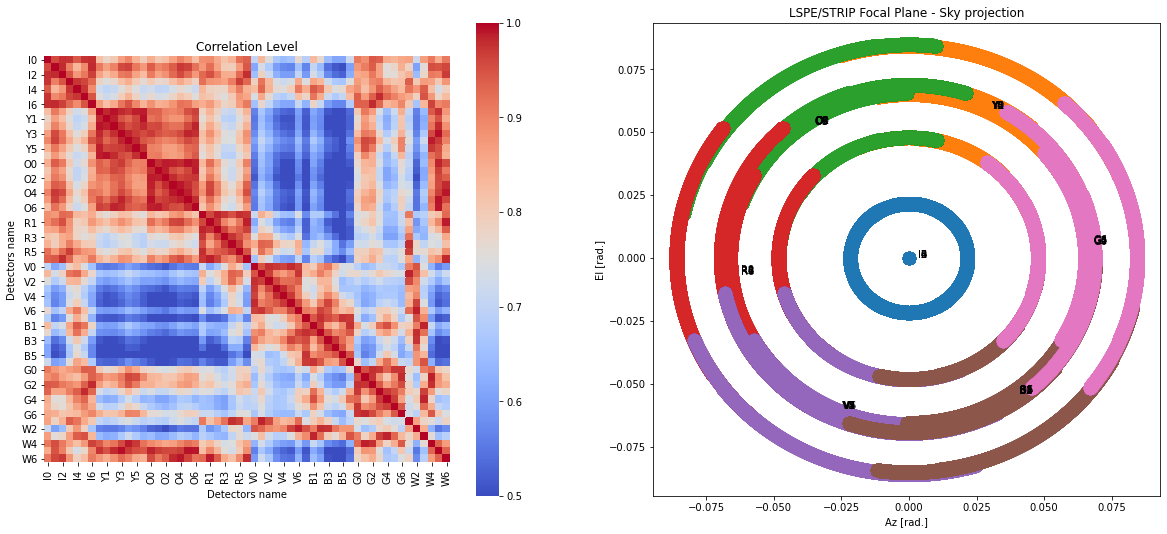

In [15]:
plt.figure(1, figsize=(20,8.7))
plt.subplot(121)
ax=sn.heatmap(MTX_CX, annot=False, cmap='coolwarm', vmin=.5, vmax=1, center=0.75, square=True)
ax.set(xlabel='Detectors name', ylabel='Detectors name', title="Correlation Level")
ax = plt.subplot(122)


ll = np.array([])
uu = np.array([])
name = np.array([])

idx=0
idx_module=0
for i in detecotrs:
    l=data.obs[0]['tod'][i]['l']
    u=data.obs[0]['tod'][i]['u']
    
    l_rot = l*np.cos(bor)-u*np.sin(bor)
    u_rot = u*np.cos(bor)+l*np.sin(bor)
    
    ll=np.append(ll, l_rot)
    uu=np.append(uu, u_rot)
    name = np.append(name, i)
    idx = idx + 1
    if (idx % 7) == 0:
        ax.scatter(ll, uu, s=150)
        for j in range(0, 7):
            ax.annotate(name[j], (ll[j]+0.0035, uu[j]))
        idx = 0
        ll = np.array([])
        uu = np.array([])
        name=np.array([])
        idx_module = idx_module + 1
plt.title("LSPE/STRIP Focal Plane - Sky projection")
plt.xlabel('Az [rad.]')
plt.ylabel('El [rad.]')



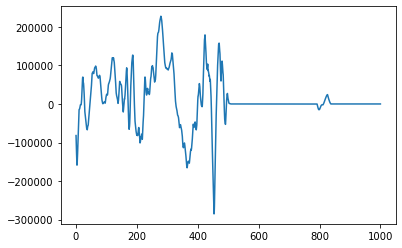

In [35]:


plt.plot(times, data.obs[0]['tod']['I0']['signal'])
#plt.plot(times, data.obs[0]['tod']['O6']['signal'])

In [18]:
abso_vec=pycal.atm_absorption_coefficient_vec(5000, 280, 101500, 5, 40, 50, 500)
load_vec=pycal.atm_atmospheric_loading_vec(5000, 280, 101500, 5, 40, 50, 500)


In [ ]:
plt.plot(np.linspace(40, 50, 500), abso_vec)
#plt.plot(np.linspace(40, 50, 500), load_vec)

In [ ]:
a=pycal.atm_absorption_coefficient(5000, 280, 101500, 2, 150)
b=pycal.atm_atmospheric_loading(5000, 280, 101500, 2, 57)

In [ ]:
print(a,b)

In [ ]:
fmin=1/300
fmax=12.5
freq=np.linspace(fmin,fmax,int(len(tod_k)/2))
tod_k_fft=np.fft.fftshift(np.fft.fft(tod_k))
plt.loglog(freq,np.real(tod_k_fft[int(len(tod_k)/2)::])**2 + np.imag(tod_k_fft[int(len(tod_k)/2)::])**2)

In [ ]:
1/170

In [ ]:
1/0.012

In [ ]:
1/25

In [ ]:
1/0.04

In [ ]:
tmax/5

In [ ]:
def get_comm():
    log = pycal.Logger.get()
    env = pycal.Environment.get()
    mpiworld, procs, rank = get_world()

    # This is the 2-level toast communicator.  By default,
    # there is just one group which spans MPI_COMM_WORLD.
    comm = Comm(world=mpiworld)
    return mpiworld, procs, rank, comm

In [ ]:
mpiworld, procs, rank, comm = get_comm()
atmsim=OpSimAtmosphere()

In [ ]:
dati=Data(comm)
dati.comm

In [ ]:
atmsim.exec(dati)

In [ ]:
from pycal.weather import *
import astropy
import datetime

In [ ]:
alto_chor=Weather("weather_QUBIC.fits",1,1)

In [ ]:
days=np.linspace(0,200000,10000)
hum=np.array([])

for i in days:
    alto_chor.set_time(int(i))
    hum=np.append(hum, alto_chor.air_temperature)


In [ ]:
plt.plot(days,hum)

In [ ]:
days

In [ ]:
datetime.datetime.utcfromtimestamp(51*365*24*60*60)

In [ ]:
24*60*60

In [ ]:
d=datetime.datetime.now()

In [ ]:
from toast.todmap.atm import AtmSim
import numpy as np
import matplotlib.pylab as plt

azmin=(14/180)*np.pi
azmax=(36/180)*np.pi
elmin=(60/180)*np.pi
elmax=(80/180)*np.pi
tmin=0.0
tmax=500
lmin_center=20
lmin_sigma=0
lmax_center=600
lmax_sigma=0
w_center=20
w_sigma=0
wdir_center=np.pi/6
wdir_sigma=0
z0_center=2000
z0_sigma=0
T0_center=280.0
T0_sigma=5.0
zatm=40000.0
zmax=2000.0
xstep=80.0
ystep=80.0
zstep=80.0
nelem_sim_max=200
verbosity=1
comm=None
key1=325
key2=10000+int(tmax)*25
counterval1=34567 
counterval2=600000
cachedir="/home/algebrato/Progetti/CMB4G/libcal/cookbook/atm_cache"
rmin=0
rmax=10000

fs_hz=25
ss=(1/180)*np.pi
times=np.linspace(0,tmax,int(tmax)*fs_hz)
el=np.ones(int(tmax)*fs_hz)*(72/180)*np.pi
# az=np.ones(int(tmax)*fs_hz)*(25/180)*np.pi

azmin_tod=(20/180)*np.pi
azmax_tod=(30/180)*np.pi
az1=np.linspace(azmin_tod,azmax_tod,10*fs_hz)
az=az1
for i in range(0, int((tmax/10)-1)):
    az1=np.flip(az1)
    az=np.append(az, az1)
tod0=np.zeros(int(tmax)*fs_hz)
tod1=np.zeros(int(tmax)*fs_hz)
tod2=np.zeros(int(tmax)*fs_hz)
tod3=np.zeros(int(tmax)*fs_hz)
tod4=np.zeros(int(tmax)*fs_hz)


In [ ]:
atmosphere=AtmSim(azmin=azmin, azmax=azmax, elmin=elmin, elmax=elmax, tmin=tmin, tmax=tmax, lmin_center=lmin_center,  lmin_sigma=lmin_sigma, 
        lmax_center=lmax_center, lmax_sigma=lmax_sigma, w_center=w_center, w_sigma=w_sigma, wdir_center=wdir_center, 
        wdir_sigma=wdir_sigma, z0_center=z0_center, z0_sigma=z0_sigma, T0_center=T0_center, T0_sigma=T0_sigma, zatm=zatm, zmax=zmax,
        xstep=xstep, ystep=ystep, zstep=zstep, nelem_sim_max=nelem_sim_max, comm=None, key1=key1, 
        key2=key2, counterval1=counterval1, counterval2=counterval2, cachedir=cachedir, rmin=rmin, rmax=rmax, write_debug=True)

In [ ]:
atmosphere.simulate()

In [ ]:
atmosphere.observe(times, az-((5/180)*np.pi), el, tod0)

In [ ]:
atmosphere.observe(times, az, el-((5/180)*np.pi), tod1)
atmosphere.observe(times, az, el, tod2)
atmosphere.observe(times, az+((5/180)*np.pi), el, tod3)
atmosphere.observe(times, az-((5/180)*np.pi), el, tod4)

In [ ]:
plt.plot(tod0)

In [ ]:
plt.figure(figsize=(15,15))
ll = np.array([])
uu = np.array([])

for i in detecotrs:
    l=data.obs[0]['tod'][i]['l']
    u=data.obs[0]['tod'][i]['u']
    ll=np.append(ll, l)
    uu=np.append(uu, u)
    
plt.plot(ll,uu, 'o')
len(detecotrs)

In [ ]:
idx=0
for i in detecotrs:
    print(i)
    idx=idx+1
    if (idx % 7) == 0:
        print("PLOT")


In [ ]:
7 % 7

ValueError: too many values to unpack (expected 2)

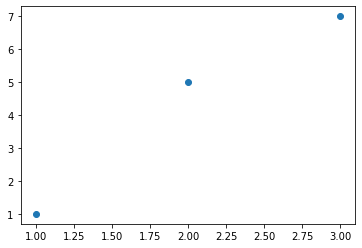

In [87]:
p=plt.scatter([1,2,3],[1,5,7])
plt.annotate((1,1),'ciao')

In [12]:
theta=np.pi/2
rot=np.matrix([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

In [13]:
a=(0,1)

a*rot

matrix([[1.000000e+00, 6.123234e-17]])

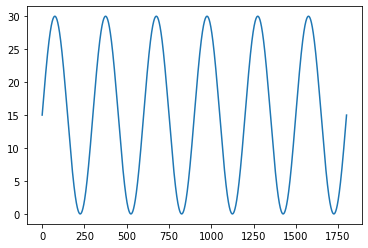

In [29]:
plt.plot(times, bor)

In [10]:
atm=pycal.AtmSim(azmin, 
                 azmax, 
                 elmin, 
                 elmax, 
                 tmin, 
                 tmax_sim, 
                 lmin_center, 
                 lmin_sigma, 
                 lmax_center, 
                 lmax_sigma, 
                 w_center, 
                 w_sigma, 
                 wdir_center, 
                 wdir_sigma, 
                 z0_center, 
                 z0_sigma, 
                 T0_center, 
                 T0_sigma, 
                 zatm, 
                 zmax, 
                 xstep, 
                 ystep, 
                 zstep, 
                 nelem_sim_max, 
                 verbosity, 
                 key1, 
                 key2+1, 
                 counterval1, 
                 counterval2, 
                 cachedir, 
                 rmin, 
                 rmax
)

In [11]:
err = atm.simulate(True)

In [12]:
for i in detecotrs:
    atm.observe(times, data.obs[0]['pointings'][i]['az'], data.obs[0]['pointings'][i]['el'], data.obs[0]['tod'][i]['signal'], -1)

## Different steps for different distanance by the telescope?